In [25]:
# Env Setup
!pip install tensorflow librosa numpy matplotlib seaborn
import os, random, math
from pathlib import Path
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 47.5 MB/s  0:00:00eta 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]


In [14]:
# Audio Parameters
SAMPLE_RATE = 8000
WINDOW_SIZE = 0.025
FFT_SIZE = int(SAMPLE_RATE * WINDOW_SIZE)
HOP_SIZE = int(0.010 * SAMPLE_RATE)
N_MFCC = 32
MAX_DURATION = 2.0
EXPECTED_SAMPLES = int(SAMPLE_RATE * MAX_DURATION)
FIXED_FRAMES = 80
print("Sample rate:", SAMPLE_RATE)

Sample rate: 8000


In [15]:
# Load file paths
lang = "es"
data_path = "../dataset"
data_root = Path(data_path + "/" + lang)   
if not data_root.exists():
    # Fallback if running from a different directory depth
    data_root = Path("voiceRover/dataset/" + lang)

label_names = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
label_to_idx = {n:i for i,n in enumerate(label_names)}

files = []
labels = []
for label in label_names:
    for f in sorted((data_root/label).glob("*.wav")):
        files.append(str(f))
        labels.append(label_to_idx[label])

print(f"Found {len(files)} files in {label_names}")

Found 40 files in ['backward', 'forward', 'left', 'right']


In [16]:
# ---- HELPER FUNCTIONS (Augmentation + Normalization) ----

def augment_audio(y, sr):
    # 1. Add Gaussian Noise
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    y = y + noise_amp * np.random.normal(size=y.shape[0])
    # 2. Time Shift
    shift_samples = int(sr * 0.1)
    shift_direction = np.random.choice([-1, 1])
    y = np.roll(y, shift_samples * shift_direction)
    return y

def extract_mfcc(path, augment=False):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    # Normalize Volume
    if y.size > 0:
        y = y / (np.max(np.abs(y)) + 1e-9)
    y, _ = librosa.effects.trim(y, top_db=20)
    
    # Augmentation
    if augment:
        y = augment_audio(y, sr)
    
    # Pad/Truncate
    if len(y) > EXPECTED_SAMPLES:
        y = y[:EXPECTED_SAMPLES]
    else:
        pad_len = EXPECTED_SAMPLES - len(y)
        if pad_len > 0:
            y = np.pad(y, (0, pad_len), mode='constant')

    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=FFT_SIZE, hop_length=HOP_SIZE)
    mfcc = mfcc.T.astype(np.float32)

    # --- NORMALIZATION (Fixes 'Flat' Image) ---
    mean = np.mean(mfcc, axis=0)
    std = np.std(mfcc, axis=0)
    mfcc = (mfcc - mean) / (std + 1e-6)
    
    return mfcc

In [17]:
# ---- DATASET EXPANSION ----
expanded_files = []
expanded_labels = []
AUGMENT_FACTOR = 50 

for f, l in zip(files, labels):
    for _ in range(AUGMENT_FACTOR):
        expanded_files.append(f)
        expanded_labels.append(l)

# Shuffle
pairs = list(zip(expanded_files, expanded_labels))
random.shuffle(pairs)
expanded_files, expanded_labels = zip(*pairs)
expanded_files = list(expanded_files)
expanded_labels = list(expanded_labels)

n_train = int(len(expanded_files) * 0.90)
print(f"New Dataset Size: {len(expanded_files)}")

New Dataset Size: 2000


In [18]:
# ---- TF PIPELINE ----
def _load_and_preprocess(path_tensor, label):
    def _py_extract_func(p):
        # Handle both bytes and string tensor types
        if isinstance(p, bytes):
            path_str = p.decode('utf-8')
        else:
            path_str = str(p.numpy().decode('utf-8')) if hasattr(p, 'numpy') else str(p)
        mf = extract_mfcc(path_str, augment=True)
        # Fix length to 80 frames
        if mf.shape[0] >= FIXED_FRAMES:
            mf_fixed = mf[:FIXED_FRAMES, :]
        else:
            pad_rows = FIXED_FRAMES - mf.shape[0]
            mf_fixed = np.vstack([mf, np.zeros((pad_rows, mf.shape[1]), dtype=np.float32)])
        return mf_fixed

    mf = tf.py_function(func=_py_extract_func, inp=[path_tensor], Tout=tf.float32)
    mf.set_shape((FIXED_FRAMES, N_MFCC))
    mf = tf.expand_dims(mf, -1)
    return mf, label

files_tf = tf.constant(expanded_files, dtype=tf.string)
labels_tf = tf.constant(expanded_labels, dtype=tf.int32)

ds_all = tf.data.Dataset.from_tensor_slices((files_tf, labels_tf))
ds_all = ds_all.shuffle(buffer_size=len(expanded_files), reshuffle_each_iteration=True)
ds_all = ds_all.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = ds_all.take(n_train).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_all.skip(n_train).batch(32).prefetch(tf.data.AUTOTUNE)

/Users/felipe.santos/Projects/voiceRover/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


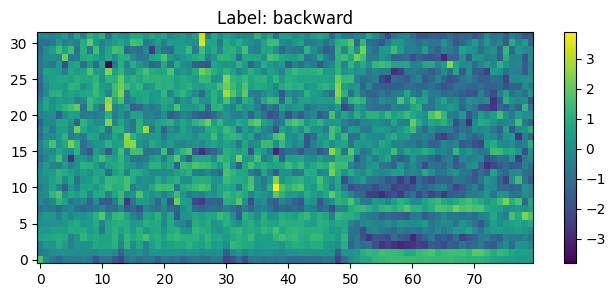

2025-12-02 14:49:18.455601: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
# Check one MFCC
for x, y in ds_all.take(1):
    plt.figure(figsize=(8,3))
    plt.imshow(x.numpy().squeeze().T, origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"Label: {label_names[y]}")
    plt.show()

In [20]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Input(shape=(FIXED_FRAMES, N_MFCC, 1)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.DepthwiseConv2D((3,3), padding='same', activation='relu'),
    layers.Conv2D(24, (3,3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(label_names), activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 80, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 80, 32, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 32, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 24)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,732 (18.48 KB)

 Trainable params: 4,732 (18.48 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(train_ds, validation_data=val_ds, epochs=60)

Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.2661 - loss: 1.3870 - val_accuracy: 0.2050 - val_loss: 1.3853
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.2733 - loss: 1.3789 - val_accuracy: 0.2700 - val_loss: 1.3785
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4272 - loss: 1.3413 - val_accuracy: 0.4900 - val_loss: 1.2829
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5317 - loss: 1.1626 - val_accuracy: 0.7000 - val_loss: 1.0082
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.7389 - loss: 0.8561 - val_accuracy: 0.7150 - val_loss: 0.7051
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.7400 - loss: 0.7002 - val_accuracy: 0.7950 - val_loss: 0.6521
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.7700 - loss: 0.6129 - val_accuracy: 0.7850 - val_loss: 0.5989
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8244 - loss: 0.5356 - val_accuracy: 0.

Scanning dataset at: ../dataset/es...
Testing 10 files for class 'backward'...


/Users/felipe.santos/Projects/voiceRover/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Testing 10 files for class 'forward'...
Testing 10 files for class 'left'...
Testing 10 files for class 'right'...

OVERALL ACCURACY: 100.00%


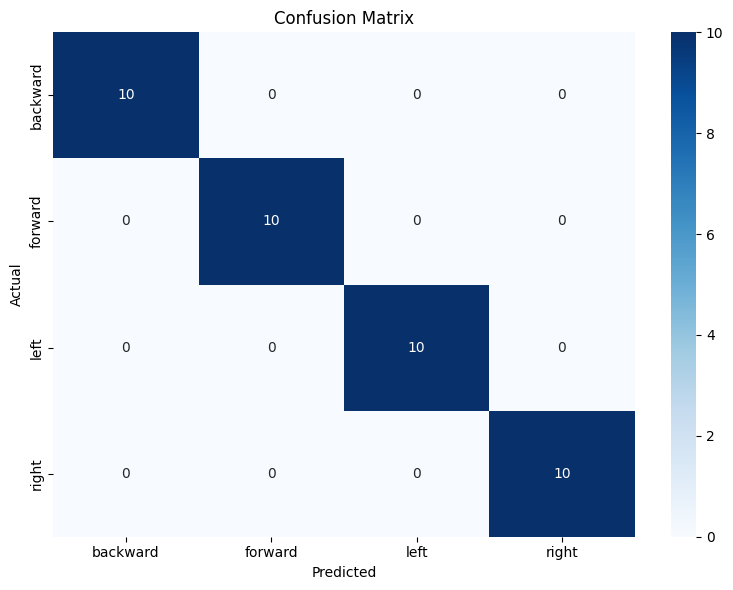


⚠️  Low Confidence Predictions (<70%):
  - record_7.wav: Real='backward' vs Pred='backward' (Conf: 0.59)
  - record_4.wav: Real='forward' vs Pred='forward' (Conf: 0.55)
  - record_6.wav: Real='left' vs Pred='left' (Conf: 0.62)
  - record_7.wav: Real='right' vs Pred='right' (Conf: 0.64)
  - record_1.wav: Real='right' vs Pred='right' (Conf: 0.57)


In [26]:
# ---- ROBUST EVALUATION & CONFUSION MATRIX ----
import matplotlib.pyplot as plt
import seaborn as sns # Optional, makes plots prettier if installed
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_whole_dataset(model, data_root, label_names):
    y_true = []
    y_pred = []
    low_confidence_files = []
    
    print(f"Scanning dataset at: {data_root}...")
    
    # 1. Iterate over every file in the dataset
    for label_idx, label in enumerate(label_names):
        folder = data_root / label
        files = list(folder.glob("*.wav"))
        print(f"Testing {len(files)} files for class '{label}'...")
        
        for f in files:
            # Run prediction logic manually to keep it fast
            # (Reusing your extraction logic)
            mfcc = extract_mfcc(str(f), augment=False)
            
            # Shape fix
            if mfcc.shape[0] >= FIXED_FRAMES:
                mfcc_fixed = mfcc[:FIXED_FRAMES, :]
            else:
                pad_rows = FIXED_FRAMES - mfcc.shape[0]
                mfcc_fixed = np.vstack([mfcc, np.zeros((pad_rows, mfcc.shape[1]), dtype=np.float32)])
            
            x = np.expand_dims(mfcc_fixed, axis=0) # Batch dim
            x = np.expand_dims(x, axis=-1)         # Channel dim
            
            # Predict
            prediction = model.predict(x, verbose=0)
            predicted_idx = np.argmax(prediction[0])
            confidence = prediction[0][predicted_idx]
            
            # Store results
            y_true.append(label_idx)
            y_pred.append(predicted_idx)
            
            # Flag low confidence (< 70%)
            if confidence < 0.70:
                low_confidence_files.append((f.name, label, label_names[predicted_idx], confidence))

    # 2. Calculate Metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    
    print("\n" + "="*40)
    print(f"OVERALL ACCURACY: {accuracy * 100:.2f}%")
    print("="*40)

    # 3. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    # Check if seaborn is available for a nicer heatmap, otherwise use standard matplotlib
    try:
        import seaborn as sns
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_names, yticklabels=label_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
    except ImportError:
        # Fallback if seaborn not installed
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        
        # Loop over data dimensions and create text annotations.
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

    # 4. Report Problematic Files
    if low_confidence_files:
        print("\n⚠️  Low Confidence Predictions (<70%):")
        for name, actual, pred, conf in low_confidence_files:
            print(f"  - {name}: Real='{actual}' vs Pred='{pred}' (Conf: {conf:.2f})")
    else:
        print("\n✅ No low confidence predictions found!")

# Run the evaluation
evaluate_whole_dataset(model, data_root, label_names)

In [23]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
    
print("Model saved to model.tflite")
# !xxd -i model.tflite > model_data.cc  # Uncomment to generate C array on Linux/Mac

INFO:tensorflow:Assets written to: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpfjh5__86/assets


INFO:tensorflow:Assets written to: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpfjh5__86/assets


Saved artifact at '/var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpfjh5__86'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 32, 1), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  13399213072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399219216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399213264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399219408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399214992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399223248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399223056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399223632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399223440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13399227472: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved 

W0000 00:00:1764698126.480573 15658238 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764698126.480583 15658238 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-02 14:55:26.481421: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpfjh5__86
2025-12-02 14:55:26.482306: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-02 14:55:26.482311: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpfjh5__86
2025-12-02 14:55:26.485496: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-02 14:55:26.503756: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpfjh5__86
2025-12-02 14:55:26.509523: I tensorflow/cc/saved_model/loader.c